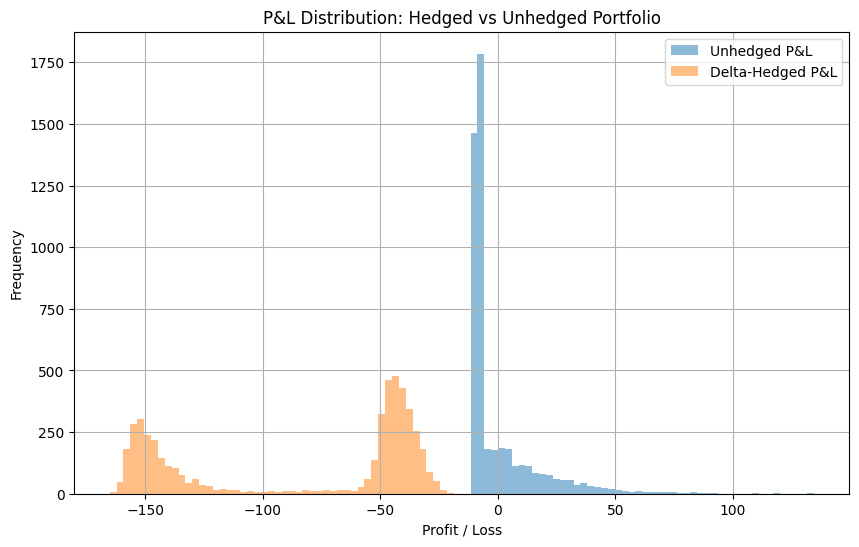

Unhedged P&L StdDev: 15.7278
Hedged P&L StdDev:   50.9616

Δ (Delta): 0.5039
Vega: 39.8923
Theta (per day): -5.8253


In [1]:
# Step 9 — Delta Hedging Simulation and Greeks Estimation
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ---------- Black–Scholes Core Functions ----------
def bs_call_price(S, K, T, r, sigma):
    """Black–Scholes call price"""
    if T <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def bs_delta(S, K, T, r, sigma):
    """Call Delta"""
    if T <= 0:
        return 1.0 if S > K else 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def bs_vega(S, K, T, r, sigma):
    """Vega = sensitivity to volatility"""
    if T <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def numerical_theta(S, K, T, r, sigma, dt=1/252):
    """Approximate Theta via finite difference"""
    C1 = bs_call_price(S, K, T, r, sigma)
    C2 = bs_call_price(S, K, max(T - dt, 1e-6), r, sigma)
    return (C2 - C1) / dt

# ---------- Delta-Hedging Monte Carlo Simulation ----------
def delta_hedging_sim(S0=100, K=105, T=1, r=0.02, sigma=0.25,
                      n_steps=252, n_sims=5000, seed=42):
    np.random.seed(seed)
    dt = T / n_steps
    drift = (r - 0.5 * sigma ** 2) * dt
    diffusion = sigma * np.sqrt(dt)

    # Simulate geometric Brownian motion
    Z = np.random.normal(0, 1, (n_sims, n_steps))
    log_paths = np.cumsum(drift + diffusion * Z, axis=1)
    S = S0 * np.exp(log_paths)
    times = np.linspace(T, 0, n_steps)

    pnl_hedged = np.zeros(n_sims)
    pnl_unhedged = np.zeros(n_sims)

    for i in range(n_sims):
        path = S[i]
        cash = 0.0

        # Initial option & delta
        option_price = bs_call_price(path[0], K, T, r, sigma)
        delta_prev = bs_delta(path[0], K, T, r, sigma)

        stock_position = -delta_prev
        cash = option_price + stock_position * path[0]

        for t in range(1, n_steps):
            tau = times[t]
            if tau <= 0:
                break
            delta_new = bs_delta(path[t], K, tau, r, sigma)
            delta_change = delta_new - delta_prev
            cash -= delta_change * path[t]
            delta_prev = delta_new

        payoff = max(path[-1] - K, 0)
        portfolio_value = payoff + stock_position * path[-1] + cash * np.exp(r * T)
        pnl_hedged[i] = portfolio_value
        pnl_unhedged[i] = payoff - option_price

    return pnl_hedged, pnl_unhedged, S

# ---------- Run Simulation ----------
pnl_hedged, pnl_unhedged, S = delta_hedging_sim()

# ---------- Plot Results ----------
plt.figure(figsize=(10,6))
plt.hist(pnl_unhedged, bins=50, alpha=0.5, label="Unhedged P&L")
plt.hist(pnl_hedged, bins=50, alpha=0.5, label="Delta-Hedged P&L")
plt.legend(); plt.grid(True)
plt.title("P&L Distribution: Hedged vs Unhedged Portfolio")
plt.xlabel("Profit / Loss"); plt.ylabel("Frequency")
plt.show()

print(f"Unhedged P&L StdDev: {np.std(pnl_unhedged):.4f}")
print(f"Hedged P&L StdDev:   {np.std(pnl_hedged):.4f}")

# ---------- Display Greeks for Current Market ----------
S, K, T, r, sigma = 100, 105, 1.0, 0.02, 0.25
print(f"\nΔ (Delta): {bs_delta(S,K,T,r,sigma):.4f}")
print(f"Vega: {bs_vega(S,K,T,r,sigma):.4f}")
print(f"Theta (per day): {numerical_theta(S,K,T,r,sigma):.4f}")
